# Homework 2: Text mining

This assignment will teach you how to use text data to build predictive models. Before starting this assignment, make sure you read the Trans-American Airlines case study. The data for the case study is in the file "tweets.csv".

## Grade Breakdown

The grade breakdown for this assignment is as follows:
1. **Questions & Code (80\%):** Most of this assignment consists of completing short snippets of code and answering questions within the Jupyter notebook. Questions do not have partial credits. You either get all the points or you don't get any, so be careful in your responses.
2. **Peer evaluation (20\%):** You and your group members must evaluate each other by completing the peer evaluation (the link is in the assignment description in Canvas). **IMPORTANT**: You will receive no credits if you do not complete your peer evaluation as part of your submission, so please be careful. One of the questions in the evaluation is this one: `Did this group member helped you submit a better assignment or in less time than what you could have done on your own?` Your grade will depend on the answer of other group members, and their grade will depend on your answer. These are the possible answers:
   * Great: "Definitely. My assignment is much better or it took me much less time than if I had done it without them." (+10% to grade, or +20% if you are in a group of 2)
   * Acceptable: "To some extent. My assignment is slightly better or it took me slightly less time than if I had done it without them." (+5% to grade, or +10% if you are in a group of 2)
   * Worrisome: "Not really. They did not save me time or help me submit a better assignment, but they gave it an honest try." (+2% to grade, or +4% if you are in a group of 2, and the person who answered this should reach out to the corresponding group member)
   * Unacceptable: "No. And they offered me very little help or no help at all." (+0%, the person who answered this should reach out to the corresponding group member, and the professor will look into it)

## Loading the data

Before you answer the questions below, let's first load the data that was labeled by your assistant. 

In [ ]:
!gdown https://drive.google.com/uc?id=15CeuAiHYat_NLYJ_r83LQUCP9DiWYdx5

Downloading...
From: https://drive.google.com/uc?id=15CeuAiHYat_NLYJ_r83LQUCP9DiWYdx5
To: /content/tweets.csv
100% 2.68M/2.68M [00:00<00:00, 155MB/s]


In [ ]:
import pandas as pd

df = pd.read_csv("tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,name,retweet_count,text,tweet_created,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,cairdin,0,@TAA What @dhepburn said.,2/24/2015 11:35,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,jnardino,0,@TAA plus you've added commercials to the expe...,2/24/2015 11:15,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,yvonnalynn,0,@TAA I didn't today... Must mean I need to tak...,2/24/2015 11:15,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,jnardino,0,@TAA it's really aggressive to blast obnoxious...,2/24/2015 11:15,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,jnardino,0,@TAA and it's a really big bad thing about it,2/24/2015 11:14,Pacific Time (US & Canada)


In [ ]:
df['negativereason'].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

## Question 1: Target Variable (1 point)

Code a function that takes the whole data set as an input and returns a binary target variable that we should predict to address the problem discussed in the case study.

In [ ]:
def get_target_variable(data):
    return data['negativereason']=='Customer Service Issue' # YOUR CODE HERE
    raise NotImplementedError()

The output of your function should be a pandas `Series` where values are either `True` or `False`. A `True` value should represent the outcome of interest (e.g., the customer is angry). Check that your function is giving the correct type of output:   

In [ ]:
y = get_target_variable(df)
assert type(y) == pd.core.series.Series
assert len(y) == len(df)
assert y.dtype == bool

In [ ]:
y

0        False
1        False
2        False
3        False
4        False
         ...  
14635    False
14636     True
14637    False
14638     True
14639    False
Name: negativereason, Length: 14640, dtype: bool

## Question 2: Building a Predictive Model (1 point)

The following code splits the data into a training set (13,640 tweets) and a holdout set (1,000 tweets). It then transforms the text of each tweet using the bag-of-words technique discussed in Chapter 10. Each possible word that could appear in a tweet is represented as a binary feature that takes a value of 1 if the word is present in the tweet and a value of 0 otherwise. 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

text_data = df['text']
text_train, text_holdout, y_train, y_holdout = train_test_split(text_data, y, test_size=1000, random_state=0)

binary_vectorizer = CountVectorizer(binary=True)
binary_vectorizer.fit(text_train)
X_binary_train = binary_vectorizer.transform(text_train)
X_binary_holdout = binary_vectorizer.transform(text_holdout)
X_binary_train

<13640x14436 sparse matrix of type '<class 'numpy.int64'>'
	with 218161 stored elements in Compressed Sparse Row format>

As you can see, the matrix that results from transforming the text in the training data consists of 13,640 rows (tweets) and 14,436 features (words)! The output above also shows that the data is being stored in a sparse matrix (as opposed to the typical dense matrix). Given the shape of the matrix, this means there are \~197 million cells that should have values. However, from the above, we can see that only \~218k cells (\~0.1% of the cells) have values! Why is this?

To save space, sklearn uses a sparse matrix. This means that only values that are not zero are stored, which saves a ton of memory and makes the computation of models much more efficient!

**Code a function that returns a logistic regression model that is trained and tuned using the training data**. Use `GridSearchCV` with 10 folds to tune the model according to AUC. Use the parameters `solver="liblinear"` and `random_state=42` for the logistic regression. Also, try the following values for the `C` parameter with the cross-validation: 0.01, 0.1, 1, 10. For more information on these parameters, [check out the documentation on logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

*Side note (and practical tip):* When you just want to do a "quick" tune of a regularization parameter (like `C`), it's a common practice to try powers of 10 (e.g., 0.01, 0.1, 1, 10).

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

def get_model(X, y):
    # YOUR CODE HERE
    logreg = LogisticRegression()
    log_grid = {"C": [0.01, 0.1, 1, 10],
              "random_state": [42], 
              "solver": ["liblinear"]}

    logreg_cv = GridSearchCV(logreg, log_grid, cv=10, scoring = 'roc_auc')
    logreg_cv.fit(X, y)
    return logreg_cv.best_estimator_
    raise NotImplementedError()

Check that your function is giving the correct type of output:

In [ ]:
my_model = get_model(X_binary_train, y_train)
assert type(my_model) == LogisticRegression 
assert len(my_model.predict(X_binary_train)) == len(y_train)

In [ ]:
my_model

LogisticRegression(C=0.1, random_state=42, solver='liblinear')

## Question 3: Most Predictive Words (0.5 points)

The code below shows the features with the largest coefficients in your model. Use it to show the most predictive words. Pick a few words that catch your attention (at least 2 or 3). Why do you think these words are predictive? 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


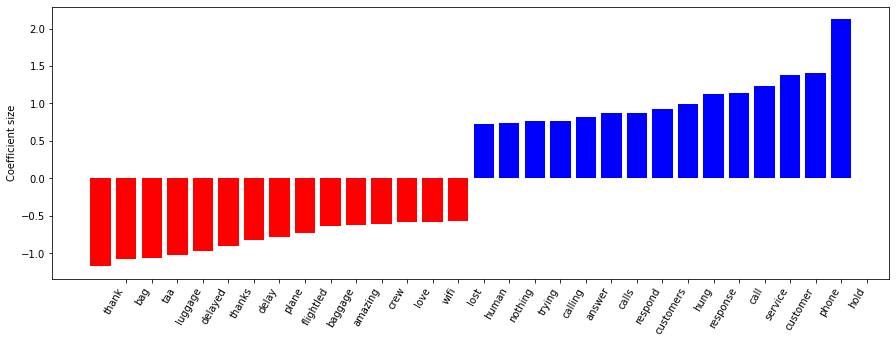

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_coefficients(classifier, feature_names, top_features=15):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
    plt.ylabel("Coefficient size")
    plt.show()
    
feature_names = binary_vectorizer.get_feature_names()
plot_coefficients(my_model, feature_names)

**ANSWER HERE**

1. **Negative Side**: "*call*", "*response*", "*nothing*" 

  Actually there are many similar words listed here, eg. calling/call/phone,or answer/response...These words all say the same thing, so We just pick two of them to explain. 
  
  They are predictive because We think they give speficic scanerios related to customer service issues. For example from those words above, We can make some fair guesses which customers might have issues when calling the Airline company and get nothing or dissatisfied reponse.

  Besides, *Customer Service Issue* is mainly caused by the customer's problem not being solved well. To solve the customer's problem, the staff needs to respond to the customer's problem in time. Therefore, "*call*" and "*response*" (or such words) are highly related to Customer Service Issue.

  "*Nothing*" is intuitively a more negative word, and the correlation with negative evaluation is relatively high.

2. **Positive Side**: "*thank(s)*", "*amazing*", "*love*"  
  
  The words We picked above are intuitively positive and may show the appreciation and gratitude of customers. So these words could show customers are relatively satisfied.

## Question 4: Text Mining Limitations (0.5 points)

For the purposes of this question, suppose we use a threshold of 0.5 to predict the target variable. The following code prints the text of five false positives and five false negatives in the validation set. Why do you think the model made these mistakes?

In [ ]:
predictions = my_model.predict(X_binary_holdout)
false_positives = text_holdout[(predictions == True) & (y_holdout == False)]
false_negatives = text_holdout[(predictions == False) & (y_holdout == True)]
print("===== FALSE POSITIVES")
print(false_positives.head(5).values)
print("===== FALSE NEGATIVES")
print(false_negatives.head(5).values)

===== FALSE POSITIVES
["@TAA In car gng to DFW. Pulled over 1hr ago - very icy roads. On-hold with AA since 1hr. Can't reach arpt for AA2450. Wat 2 do?"
 '@TAA Can you find us a flt out of LAX that is sooner than midnight on Monday? That would be great customer service 😃'
 '@TAA customer service at its finest'
 '@TAA you should be contacting her for a refund - dm me and I will provide phone number'
 '@TAA VERY upset that I cannot select seats for Tuesday flight online or over the phone. Terrible customer service :( Please help!']
===== FALSE NEGATIVES
['@TAA still no response from AA. great job guys!'
 '@TAA hello??? Anyone there?'
 "@TAA Didn't see travel had to be compete for unused funds by expiration date hidden in the fine print. Never saw that before."
 '@TAA awesome... Doors close in 2 minutes, flight leaves in 17 minutes... And the plane just got here. WTH?'
 '@TAA nothing to do with Mother Nature, more like poor commutation.']


In [ ]:
X_binary_holdout

<1000x14436 sparse matrix of type '<class 'numpy.int64'>'
	with 15491 stored elements in Compressed Sparse Row format>

**ANSWER HERE**

Reason might be that we did not do the word normalization and stemming... 
we also not use the TF-IDF method to examine the relative importance of words frequency in one document and frequencies among the entire corpus. 
So, the problem is that many irrelevant words exist and blur the original meaning that we want to catch, and eventually it makes such mistake. 

FP:
* It looks like a service, but it actually refers to crew services such as aircraft transportation/reservation
* Words such as customer and service are classified as likely to be complaints by that regression, so they are misjudged ('customer service at its finest')
* Abbreviation not recognized

FN:
* Unable to recognize sarcasm ('still no response from AA. ***great job guys***!')
* does not use the word about service, but actually says service (hello??? Anyone there?')




## Question 5: Model Evaluation (2 points)

Based on the case study information, choose one of the following measures to evaluate your model:
* Accuracy
* Expected Value
* AUC
* Precision
* Recall

Then, code a function called `get_evaluation` that evaluates the performance of your model according to this measure. This function should receive two parameters: the labeled data in the holdout set and the probability predictions made by your model in the holdout set. To obtain full marks, you must choose the most appropriate evaluation measure and code it correctly. You are only allowed to use standard Python, scikit-learn, pandas, or numpy for this task.

Print the model's performance. Do you think this performance is acceptable from a business perspective? Justify your answer. 

In [ ]:
from sklearn import metrics
def get_evaluation(y, probs):
    # YOUR CODE HERE
    auc = metrics.roc_auc_score(y, probs)
    return auc
    raise NotImplementedError()

Check that your function is giving the right output:

In [ ]:
probabilities = my_model.predict_proba(X_binary_holdout)[:, 1]
result = get_evaluation(y_holdout, probabilities)
print(result)

0.8643341551703588


**ANSWER HERE**

We think AUC is the most appropriate evaluation measure as it balanced the different thresholds and give us a nice result. 

In this case, the model is acceptable because the AUC value for the model (AUC=0.86) is much larger than random (AUC=0.5).

But if we count the probability such that when it is larger than 0.5, then we think the customer is angry about the customer service issue, then the recall score (TP/(TP+FN)) is 0.45, which means we can only identify less than a half message which is true.  So this method, to some extent, may lose some important angry messages.

## Question 6: Using the model (0.5 point)

Print the top 20 tweets in the holdout set with the highest probability of having a positive value for the target variable. What seems to be the main problem that Trans-American Airlines is facing?

In [ ]:
# YOUR CODE HERE
def high_p20(model, X, y):
  prob_T = pd.Series(model.predict_proba(X)[:,1], index = y.index)
  prob_T.sort_values(ascending = False, inplace = True)
  return text_holdout[prob_T[:20].index].values
  raise NotImplementedError() 
  
top_20 = high_p20(my_model, X_binary_holdout, y_holdout)
print(top_20)


['@TAA I have been on hold w/customer service line for 68 minutes.  This after I was on phone with an agent for 35 min b/f call droped'
 '@TAA was wondering is there a reason why customer service is so busy? Been on hold past few days for many hours No answer Help plz'
 '@TAA I waited customer service 32 minutes on the phone w/o response. Had to hung up in the end since my battery died due to waiting!'
 "@TAA I'm really glad I just waited on the phone for over an hour to be sent to a voicemail. Your customer service sucks. Nothing has been"
 '@TAA Hold for 15 min, a couple of rings, then "mailbox has not been set up yet." Customer service forwarding to their cell phones? C\'mon'
 "@TAA trying to change my reservation, been on hold for 45 minutes, and can't do it online-was directed to call. Help?"
 "@TAA @EdPlotts don't bother trying to get anywhere with their customer service team either as take 2+ months and counting to reply"
 "@TAA  after 38 minutes on the phone I'm given another n

**ANSWER HERE**

[**basically regarding the customer service phone call issue**], to be more specific: 

1.customer service center did not pick up the phone on time, long waiting for customers;

2.poor call-back system 

3.hang-up VIP customers' phone calls

## Question 7: Conduct Benchmark (2 points)

There are several options for transforming text into features besides using 1s and 0s to represent the presence or absence of a word. For example you can use integers to indicate how many times words appear; the term frequency - inverse document frequency (tf-idf) measure is another popular alternative (see Chapter 10 of the book). The code below shows how to transform text into features using these two other approaches. 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# transform text to word counts (binary)
count_vectorizer_binary = CountVectorizer(binary=True)
count_vectorizer_binary.fit(text_train)
X_count_train_binary = count_vectorizer_binary.transform(text_train)

# transform text to word counts
count_vectorizer = CountVectorizer()
count_vectorizer.fit(text_train)
X_count_train = count_vectorizer.transform(text_train)

# transform text to tf-idf
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(text_train)
X_tfidf_train = tfidf_vectorizer.transform(text_train)

Code a function that benchmarks the following approaches to transform text data into features:
* `CountVectorizer(binary=True)`
* `CountVectorizer()`
* `TfidfVectorizer()`

The function must:
* Learn and tune models using the function `get_model` you coded for Question 2. As before, use the training data to train and tune models.
* Evaluate the models using the function `get_evaluation` you coded for Question 5. As before, use the test data to evaluate the models.
* Return a list with the evaluation performance of the three methods. The first element should correspond to `CountVectorizer(binary=True)`, the second element to `CountVectorizer()`, and the third element to `TfidfVectorizer()`.

In [ ]:
from sklearn import metrics

def conduct_benchmark(text_train, text_val, y_train, y_val):
    #CODE HERE
    performance = []

    # transform text to word counts (binary)
    binary_vectorizer = CountVectorizer(binary=True)
    binary_vectorizer.fit(text_train)
    X_binary_train = binary_vectorizer.transform(text_train)
    X_binary_holdout = binary_vectorizer.transform(text_holdout)

    cvb = get_model(X_binary_train, y_train)
    prob_cvb = cvb.predict_proba(X_binary_holdout)[:, 1]
    performance.append(get_evaluation(y_holdout, prob_cvb))

    # transform text to word counts
    count_vectorizer = CountVectorizer()
    count_vectorizer.fit(text_train)
    X_count_train = count_vectorizer.transform(text_train)
    X_count_holdout = count_vectorizer.transform(text_holdout)
    
    cv = get_model(X_count_train, y_train)
    prob_cv = cv.predict_proba(X_count_holdout)[:, 1]
    performance.append(get_evaluation(y_holdout, prob_cv))

    # transform text to tf-idf
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer.fit(text_train)
    X_tfidf_train = tfidf_vectorizer.transform(text_train)
    X_tfidf_holdout = tfidf_vectorizer.transform(text_holdout)

    tfidf = get_model(X_tfidf_train, y_train)
    prob_tfidf = tfidf.predict_proba(X_tfidf_holdout)[:, 1]
    performance.append(get_evaluation(y_holdout, prob_tfidf))
    return performance
    raise NotImplementedError()

Check that your function is returning a list with 3 numbers. 

In [ ]:
benchmark = conduct_benchmark(text_train, text_holdout, y_train, y_holdout)
assert len(benchmark) == 3
#print(benchmark)

[0.8643341551703588, 0.8654383026242323, 0.8678975401351325]


## Question 8: Interpret Benchmark (0.5 points)

Take a look at the benchmark results. Do you think the difference in performance is large or small? Why do you think the difference in performance is large/small? Justify your answer.

In [ ]:
pd.DataFrame({"Approach":['binary', 'count', 'tfidf'], "Performance":benchmark})

,Approach,Performance
0,binary,0.864334
1,count,0.865438
2,tfidf,0.867898


**ANSWER HERE**

We think the difference in performance is small since the performance difference between the three approaches is less than  0.5%.

Due to the result, most of the words (95%) only exist once, and the maximum occurrence number of the word is 6; thus, counting words based on binary or occurrence numbers doesn't matter more in the result. And also, because there's no word showing high frequency in the text, multiplying inverse document frequency doesn't affect much of the solution, that's why the three methods output nearly identical. 




In [ ]:
# Return how many percents of words only shown once
1- ((X_count_train - X_binary_train).count_nonzero() / X_count_train.count_nonzero())

0.9477358464620166

In [ ]:
# Return the maximum occurrence
X_count_train.max(axis=None, out=None)

6